In [1]:
# !pip install pymc
# !pip install pyreadstat 
# sav_data = pd.read_spss('sav_data.sav"')"
# sav_data.to_csv('csv_data.csv', index=False)

In [23]:
#@title Imports and load google drive, navigate to BPD folder
import pandas as pd
import numpy as np
import scipy.stats as stat
import arviz as az
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.optimize import minimize
# import pytensor
# import pytensor.tensor as pt
import scipy
import hddm
import seaborn as sns
import pymc
from pymc import geweke, Matplot

# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import multiprocessing as mp



In [53]:
data = pd.read_csv('new_d.csv').drop('Unnamed: 0', axis = 1)
data = data.sort_values(['ID', 'Session', 'Block'], ascending=[True, True, True]).reset_index().drop('index', axis = 1)
data['optimal response taken'] = data['StimulusPresentation1.RESP'] == data['StimulusPresentation1.CRESP']

In [15]:
ds = pd.read_csv('df_stressed.csv')

In [17]:
ds['feedback']

0        1
1        1
2        0
3        1
4        0
        ..
24055    1
24056    1
24057    1
24058    1
24059    0
Name: feedback, Length: 24060, dtype: int64

,Unnamed: 0,subj_idx,response,feedback,cond,Session,trial,rt,q_init,split_by,BPD,Condition
0,0,0,1,1,AB,Neutral,0.0,0.5,0.5,0.0,No BPD,1
1,1,0,1,1,EF,Neutral,0.0,0.5,0.5,2.0,No BPD,1
2,2,0,0,0,CD,Neutral,0.0,0.5,0.5,1.0,No BPD,1
3,3,0,0,0,CD,Neutral,1.0,0.5,0.5,1.0,No BPD,1
4,4,0,1,1,AB,Neutral,1.0,0.5,0.5,0.0,No BPD,1
...,...,...,...,...,...,...,...,...,...,...,...,...
24055,24055,147,1,1,AB,Stressed,18.0,0.5,0.5,0.0,No BPD,2
24056,24056,147,1,1,EF,Stressed,18.0,0.5,0.5,2.0,No BPD,2
24057,24057,147,1,1,EF,Stressed,19.0,0.5,0.5,2.0,No BPD,2
24058,24058,147,1,1,AB,Stressed,19.0,0.5,0.5,0.0,No BPD,2


In [4]:
#Generated trial behavior
num_trials = 360
possible_trials = np.concatenate((np.tile([[0, 1]], int(num_trials/3)).reshape(int(num_trials/3), 2), np.tile([[2, 3]], int(num_trials/3)).reshape(int(num_trials/3), 2), np.tile([[4, 5]], int(num_trials/3)).reshape(int(num_trials/3), 2)))
np.random.shuffle(possible_trials)

rewards = np.zeros_like(possible_trials)
for i, trial in enumerate(possible_trials): 
    if trial[0] == 0:
        rewards[i][0] = np.random.choice([1, 0], p = [.80, .20])
        rewards[i][1] = np.random.choice([0, 1], p = [.80, .20])
    elif trial[0] == 2: 
        rewards[i][0] = np.random.choice([1, 0], p = [.70, .30])
        rewards[i][1] = np.random.choice([0, 1], p = [.70, .30])
    else:
        rewards[i][0] = np.random.choice([1, 0], p = [.60, .40])
        rewards[i][1] = np.random.choice([0, 1], p = [.60, .40])
        
optimal_choices = np.zeros(num_trials)
optimal_choices[np.where(possible_trials == [2])[0]] = 2
optimal_choices[np.where(possible_trials == [4])[0]] = 4


In [27]:
ID = 1006
trials_presented = np.array([np.array([int(i), int(j)]) for i, j in data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].str.replace('A', '0').str.replace('B', '1').str.replace('C', '2').str.replace('D', '3').str.replace('E', '4').str.replace('F', '5').values])

actions = np.zeros(len(trials_presented))
chosen = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.RESP'].values.astype(int)
for i, trial in enumerate(trials_presented):
    actions[i] = int(trial[1 - chosen[i]])
actions = actions.astype(int)

optimal_resp = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'optimal response taken'].values.astype(int)

rewards = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.ACC'].values.astype(int)


In [5]:
rng = np.random.default_rng(12345)

def generate_data(rng, alpha_l, alpha_g, beta, stimuli, p_r=None):
    n = len(stimuli)
    if p_r is None:
        p_r = [0.8, 0.2, 0.7, 0.3, 0.6, 0.4]
    actions = np.zeros(n, dtype="int")
    optimal_action_taken = np.zeros(n, dtype="int")
    rewards = np.zeros(n, dtype="int")
    Qs = np.zeros((n, len(p_r)))

    # Initialize Q table
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(Q[stimuli[i]]*beta)
        prob_a = exp_Q / np.sum(exp_Q)
        # print(prob_a)
        # Simulate choice and reward
        a = rng.choice(stimuli[i], p=prob_a)
        r = rng.random() < p_r[a]

        # Update Q table
        pred_error = r - Q[a]
        if pred_error > 0:
            alpha = alpha_g
        else:
            alpha = alpha_l

        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        optimal_action_taken[i] = int(a%2 == 0)
        Qs[i][a] = Q[a]

    return actions, rewards, optimal_action_taken, Qs

In [29]:
actions, rewards, opt_act, Qs = generate_data(rng, 1, 1, 1, trials_presented.astype(int))

In [213]:
# true_alpha_l = 0.1
# true_alpha_g = 0.4
# true_beta = 10
data.loc[data['ID'] == 1002, 'Session'].unique()

array([1, 2])

In [54]:
df_list = []
procedure = 'Trainb'
p_id = 0
for ID in data['ID'].unique():
    if len(data.loc[data['ID'] == ID, 'Session'].unique()) < 2: #Skip single session participants
        continue
    trials_presented = np.array([np.array([int(i), int(j)]) for i, j in data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].str.replace('A', '0').str.replace('B', '1').str.replace('C', '2').str.replace('D', '3').str.replace('E', '4').str.replace('F', '5').values])

    # actions, rewards, optimal_action_taken, Qs = generate_data(rng, true_alpha_l, true_alpha_g, true_beta, trials_presented, p_r=None)

    actions = np.zeros(len(trials_presented))
    chosen = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.RESP'].values.astype(int)
    for i, trial in enumerate(trials_presented):
        try:
            actions[i] = int(trial[1 - chosen[i]])
        except:
            continue
#             print(actions[i])
#             print(ID)
    actions = actions.astype(int)

    optimal_resp = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'optimal response taken'].values.astype(int)

    rewards = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'StimulusPresentation1.ACC'].values.astype(int)

#     sessions = pd.
    trials_presented = data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'TrialType'].values
    trials_presented[trials_presented == 'BA'] = 'AB'
    trials_presented[trials_presented == 'DC'] = 'CD'
    trials_presented[trials_presented == 'FE'] = 'EF'

    df = pd.DataFrame({'subj_idx': np.repeat(p_id, len(trials_presented)),
                       'response': optimal_resp,
                       'feedback': rewards.astype(float),
                       'cond': trials_presented,
                       'Session': data.loc[((data['ID'] == ID) & (data['Procedure'] == procedure)), 'Session'].values
                      }                 
                     )
    df.loc[((df['cond'] == 'AB') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'AB') & (df['Session'] == 1))]))
    df.loc[((df['cond'] == 'CD') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'CD') & (df['Session'] == 1))]))
    df.loc[((df['cond'] == 'EF') & (df['Session'] == 1)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'EF') & (df['Session'] == 1))]))

    df.loc[((df['cond'] == 'AB') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'AB') & (df['Session'] == 2))]))
    df.loc[((df['cond'] == 'CD') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'CD') & (df['Session'] == 2))]))
    df.loc[((df['cond'] == 'EF') & (df['Session'] == 2)), 'trial'] = np.arange(len(df.loc[((df['cond'] == 'EF') & (df['Session'] == 2))]))
    
    
    df['rt'] = 0.5
    df['q_init'] = 0.5
    df.loc[((df['cond'] == 'AB')), 'split_by'] = int(0)
    df.loc[((df['cond'] == 'CD')), 'split_by'] = int(1)
    df.loc[((df['cond'] == 'EF')), 'split_by'] = int(2)

    if (data.loc[data['ID'] == ID, 'BPD#'].unique()[0] > 5):
        df['BPD'] = 'BPD'
    else:
        df['BPD'] = 'No BPD'
    df['Condition'] = str(data.loc[data['ID'] == ID, 'Condition'].unique()[0])
    
    df_list.append(df)
    p_id = p_id + 1

/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in long_scalars
  from ipykernel import kernelapp as app
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: Ru

In [55]:
df = pd.concat(df_list)
# df.loc[df['BPD'] == False] = 'No BPD'


In [56]:
df.loc[df['Session'] == 1, 'Session'] = 'Neutral'
df.loc[df['Session'] == 2, 'Session'] = 'Stressed'

df.loc[df['Condition'] == 1, 'Condition'] = 'NonSocial'
df.loc[df['Condition'] == 2, 'Condition'] = 'Social'



In [25]:
df_stressed = df.loc[df.Session == 'Stressed'].reset_index().drop('index', axis = 1)
df_neutral = df.loc[df.Session == 'Neutral'].reset_index().drop('index', axis = 1)


In [27]:
df_stressed.to_csv('df_stressed.csv')
df_neutral.to_csv('df_neutral.csv')

# Hierarchical Model

In [324]:
m_hrl = hddm.Hrl(df, depends_on = {'alpha':['Session', 'BPD', 'Condition'], 'pos_alpha':['Session', 'BPD', 'Condition'], 'v':['Session', 'BPD', 'Condition']}, p_outlier = 0.05, dual = True)
m_hrl.sample(4000, burn=1000, dbname="traces.db", db="pickle")


No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.8/site-packages/hddm/models/base.py:1307: UserWarning:  
 Your include statement misses either the v, a or t parameters. 
Parameters not explicitly included will be set to the defaults, 
which you can find in the model_config dictionary!
  warnings.warn(


 [-----------------100%-----------------] 4001 of 4000 complete in 1919.5 sec

In [242]:
traces = m_hrl.get_traces()

In [245]:
traces.to_csv('traces.csv')

In [327]:
stat_traces = m_hrl.gen_stats().reset_index()
stat_traces = stat_traces.rename(columns={'index':'parameters'})

In [328]:
stat_traces.to_csv('stat_traces.csv')

In [399]:
def plotting_q(stat_traces, condition):

    alpha_g25 = stat_traces.loc[((stat_traces.parameters.str.contains(condition)) & (stat_traces.parameters.str.contains('pos_alpha_sub')))]['2.5q'].values
    alpha_g975 = stat_traces.loc[((stat_traces.parameters.str.contains(condition)) & (stat_traces.parameters.str.contains('pos_alpha_sub')))]['97.5q'].values

    alpha_l25 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('alpha_sub')]['2.5q'].values
    alpha_l975 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('alpha_sub')]['97.5q'].values

    beta_25 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('v_sub')]['2.5q'].values
    beta_975 = stat_traces[stat_traces.parameters.str.contains(condition) & stat_traces.parameters.str.startswith('v_sub')]['97.5q'].values

    alpha_g25 = np.exp(alpha_g25.astype(float))/(1+np.exp(alpha_g25.astype(float)))
    alpha_g975 = np.exp(alpha_g975.astype(float))/(1+np.exp(alpha_g975.astype(float)))

    alpha_l25 = np.exp(alpha_l25.astype(float))/(1+np.exp(alpha_l25.astype(float)))
    alpha_l975 = np.exp(alpha_l975.astype(float))/(1+np.exp(alpha_l975.astype(float)))
    print(alpha_l25)
    
    plt.subplot(1, 3, 1)
    plt.plot([alpha_g25, alpha_g975], [0.1*np.arange(len(alpha_g25)), 0.1*np.arange(len(alpha_g975))])
    plt.xlim((0, 1))
#     plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Alpha Gain')
#     plt.show()

    plt.subplot(1, 3, 2)
    plt.plot([alpha_l25, alpha_l975], [0.1*np.arange(len(alpha_l25)), 0.1*np.arange(len(alpha_l975))])
    plt.xlim((0, 1))
#     plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Alpha Loss')
#     plt.show()
    
    
    plt.subplot(1, 3, 3)
    plt.plot([beta_25, beta_975], [0.1*np.arange(len(beta_25)), 0.1*np.arange(len(beta_975))])
    plt.xlim((0, 1))
    plt.ylabel('Participants')
    plt.xlabel('HDIs')
    plt.title('Beta')
    plt.show()

[0.00335162 0.00248443 0.00260421 0.00091698 0.14987775 0.0060188
 0.00041901 0.00688423 0.00104464 0.00743658 0.04734519 0.00721574
 0.00380042]


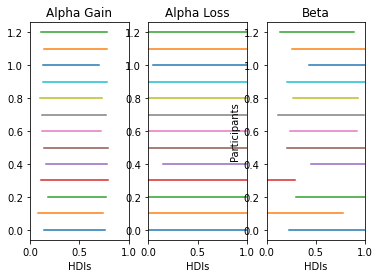

In [418]:
plotting_q(stat_traces, '\(BPD.2.Stressed')

# Non Hierarchical Model

In [299]:
df_to_fit  = pd.read_csv('df_stressed.csv')
non_hrl_stressed_traces = []
def fit_nonhrl(subject):
    print('Subject: ', subject)
    temp_df = df_to_fit.loc[df_stressed.subj_idx == subject].reset_index().drop('index', axis = 1)
    m_non_hrl_stressed = hddm.Hrl(temp_df, p_outlier = 0.05, dual = True)
    # m_non_hrl_stressed.find_starting_values()
    m_non_hrl_stressed.sample(4000, burn=1000, dbname="traces.db", db="pickle")
    return m_non_hrl_stressed.get_traces()

In [ ]:
non_hrl_startingvals_traces.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float)))


In [12]:
non_hierarchical_rl_stats = m_non_hierarchical_rl.gen_stats().reset_index().rename(columns = {'index':'parameters'})

In [13]:
non_hierarchical_rl_stats.to_csv('non_hierarchical_rl_stats_thin5.csv')


In [17]:
non_hrl_params = non_hierarchical_rl_stats[['parameters', 'mean', '50q']]


In [18]:
non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), '50q'].values.astype(float)))
non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'] = np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'].values.astype(float))/(1+ np.exp(non_hrl_params.loc[non_hrl_params.parameters.str.contains('alpha'), 'mean'].values.astype(float)))


/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
non_hrl_params.to_csv('non_hrl_params_thin5.csv')

# Models using Traces

In [69]:
traces = pd.read_csv('non_hierarchical_traces.csv').drop('Unnamed: 0', axis = 1).reset_index().rename(columns = {'index':'trace#'})

In [27]:
rng = np.random.default_rng()

In [71]:
new_traces = pd.DataFrame({'trace#': np.arange(3000)})
for column in traces.columns:
    new_traces[column] = rng.permuted(traces[column].values)

/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_traces[column] = rng.permuted(traces[column].values)
/tmp/ipykernel_5255/3584588551.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 

In [85]:
traces_melt = new_traces.melt(id_vars='trace#', var_name='parameters', value_name='parameter values')

In [76]:
traces_melt = traces.melt(id_vars='trace#', var_name='parameters', value_name='parameter values')

In [77]:
traces_melt = traces_melt[traces_melt.parameters.str.contains('subj')]

In [78]:
traces_melt.loc[traces_melt.parameters.str.contains('Neutral'), 'Session'] = 'Neutral'
traces_melt.loc[traces_melt.parameters.str.contains('Stressed'), 'Session'] = 'Stressed'



In [79]:
traces_melt[['parameters', 'ID']] = traces_melt.parameters.str.split('.', expand=True)

In [89]:
traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values'] = np.exp(traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values'])/(1+np.exp(traces_melt.loc[traces_melt.parameters.str.contains('alpha'), 'parameter values']))

In [91]:
for ids in traces_melt.ID.unique():
    traces_melt.loc[traces_melt['ID'] == ids, 'BPD'] = data.loc[data['ID'] == int(ids), 'BPD#'].unique()[0]
    traces_melt.loc[traces_melt['ID'] == ids, 'Condition'] = data.loc[data['ID'] == int(ids), 'Condition'].unique()[0]
    

In [92]:
traces_melt

,trace#,parameters,parameter values,Session,ID,BPD,Condition
9000,0,v_subj(Neutral),0.029903,Neutral,1001,0.0,2.0
9001,1,v_subj(Neutral),0.366367,Neutral,1001,0.0,2.0
9002,2,v_subj(Neutral),0.229726,Neutral,1001,0.0,2.0
9003,3,v_subj(Neutral),0.162186,Neutral,1001,0.0,2.0
9004,4,v_subj(Neutral),0.379577,Neutral,1001,0.0,2.0
...,...,...,...,...,...,...,...
2735995,2995,pos_alpha_subj(Stressed),0.142009,Stressed,1249,4.0,2.0
2735996,2996,pos_alpha_subj(Stressed),0.254487,Stressed,1249,4.0,2.0
2735997,2997,pos_alpha_subj(Stressed),0.384634,Stressed,1249,4.0,2.0
2735998,2998,pos_alpha_subj(Stressed),0.500698,Stressed,1249,4.0,2.0


In [11]:
def lm_params(trace_no, parameter = 'pos_alpha_subj'):
    temp_data = traces_melt.loc[((traces_melt['trace#'] ==trace_no) & (traces_melt['parameters'].str.startswith(parameters)))].rename(columns={'parameter values':'param_vals'})
    res = smf.ols(formula='param_vals ~  BPD*Session*C(Condition) -1 ', data=temp_data).fit()
#     d_list.append(pd.DataFrame(res.params))
    return res.params

In [ ]:
trace_nos = np.arange(3000)
pool = mp.Pool()
pos_alpha_results = pool.map(lm_params, trace_nos)

In [3]:
# pos_alpha = lm_params('pos_alpha_subj')
# neg_alpha = lm_params('pos_alpha_subj')
# beta = lm_params('v_subj')


In [139]:
pos_alpha = pos_alpha.reset_index().rename(columns={'index':'coefficient'})

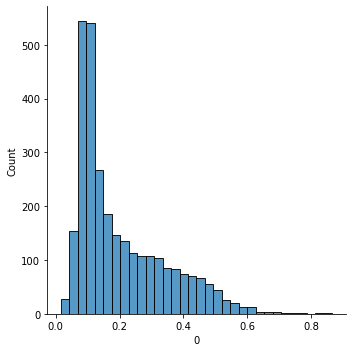

In [166]:
sns.displot(pos_alpha.iloc[0][1:])

# Analyzing/Plotting Fit Linear Model parameters

In [4]:
alpha_g = pd.read_csv('LR coefficients/mean_centered_shuffled_alpha_g.csv').drop('Unnamed: 0', axis = 1)
alpha_l = pd.read_csv('LR coefficients/mean_centered_shuffled_alpha_l.csv').drop('Unnamed: 0', axis = 1)
beta = pd.read_csv('LR coefficients/mean_centered_shuffled_beta.csv').drop('Unnamed: 0', axis = 1)

In [5]:
alpha_g_melt = alpha_g.melt(id_vars='coefficient', value_name='value', var_name='trace')
alpha_l_melt = alpha_l.melt(id_vars='coefficient', value_name='value', var_name='trace')
beta_melt = beta.melt(id_vars='coefficient', value_name='value', var_name='trace')


In [12]:
sns.set_palette('colorblind')

Text(0.5, 1.0, 'Alpha Gain')

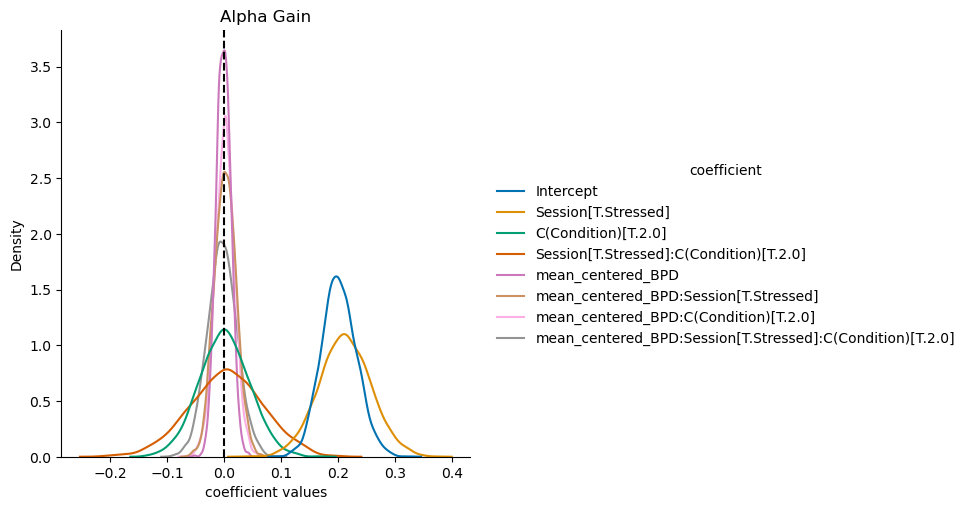

In [13]:
g = sns.displot(alpha_g_melt, kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Alpha Gain')
# sns.displot(alpha_g.iloc[0][1:])


Text(0.5, 1.0, 'Alpha Loss')

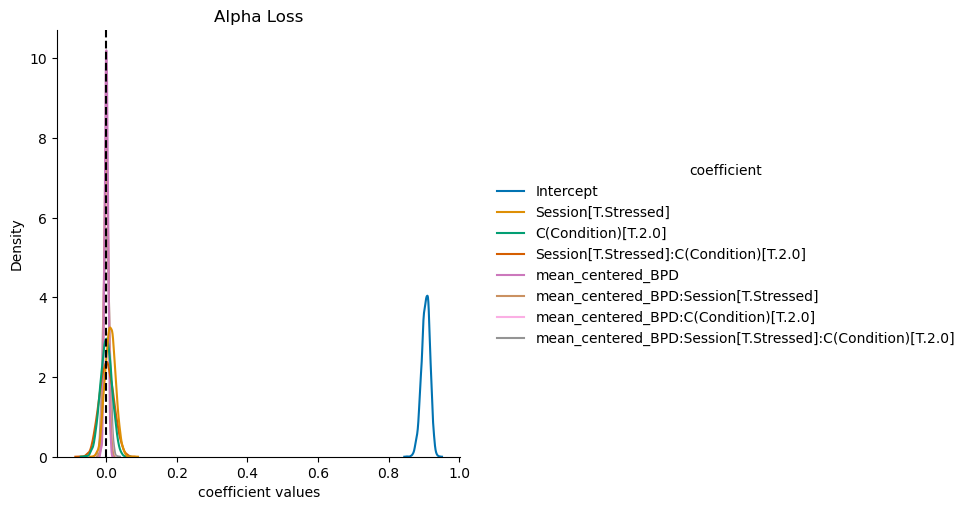

In [14]:
g = sns.displot(alpha_l_melt, kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Alpha Loss')

Text(0.5, 1.0, 'Beta')

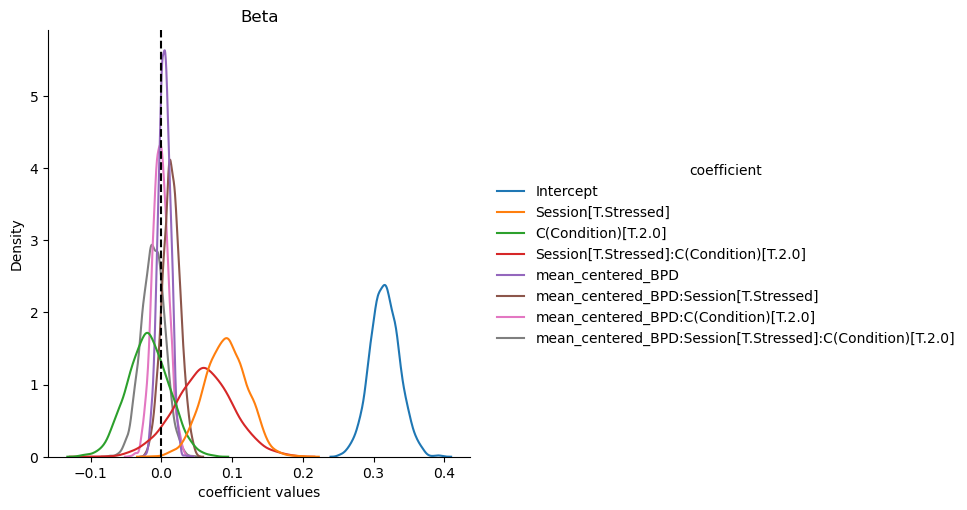

In [8]:
g = sns.displot(beta_melt, kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Beta')

Text(0.5, 1.0, 'Beta')

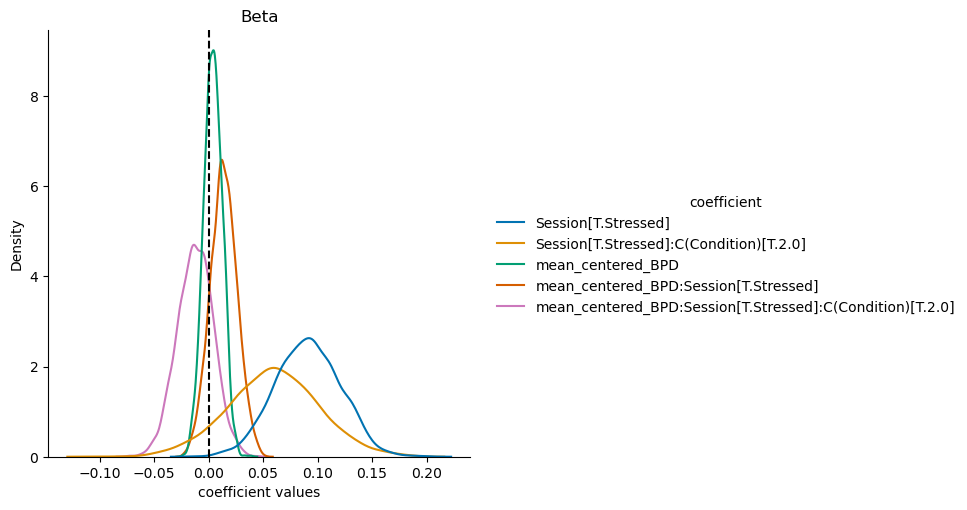

In [22]:
g = sns.displot(beta_melt.loc[((beta_melt['coefficient'] == 'mean_centered_BPD:Session[T.Stressed]') | (beta_melt['coefficient'] == 'mean_centered_BPD') | (beta_melt['coefficient'] == 'Session[T.Stressed]:C(Condition)[T.2.0]') | (beta_melt['coefficient'] == 'mean_centered_BPD:Session[T.Stressed]:C(Condition)[T.2.0]') | (beta_melt['coefficient'] == 'Session[T.Stressed]'))], 
                kind = 'kde', hue = 'coefficient', x = 'value')
g.axes[0][0].axvline(x = 0, ls = '--', color = 'black')
g.axes[0][0].set_xlabel('coefficient values')
g.axes[0][0].set_title('Beta')

In [ ]:
sns.displot(alpha_g_melt, kind = 'kde', hue = 'coefficient', x = 'value')

### Correlations and Autocorrelations 

In [29]:
traces = pd.read_csv('model_traces/10k4k5p6thin_indsubj_AB_traces.csv').drop(['Unnamed: 0'], axis = 1).reset_index().rename(columns = {'index':'trace#'})

In [30]:
traces

,trace#,v(Neutral),v(Stressed),alpha(Neutral),alpha(Stressed),pos_alpha(Neutral),pos_alpha(Stressed),subject
0,0,0.139868,4.329851,-0.004933,-6.697043,-2.079604,1.462958,0
1,1,0.111372,5.284185,4.928538,-0.358189,2.020511,1.052320,0
2,2,-0.080578,6.066973,0.210037,-1.052887,-2.116972,1.493313,0
3,3,-0.191373,3.269868,-2.836402,-2.719862,1.626625,5.229005,0
4,4,0.227803,4.802392,3.126884,4.519688,-2.188286,0.855359,0
...,...,...,...,...,...,...,...,...
147995,147995,1.244730,3.238843,2.697424,-0.330305,0.740586,3.644692,147
147996,147996,1.646085,1.739077,-4.701215,2.528460,-1.830199,-1.455220,147
147997,147997,1.746877,4.033734,-1.698925,-1.177748,0.469425,-1.999658,147
147998,147998,1.962292,4.835832,2.245032,-2.264415,2.706750,1.998072,147


In [31]:
# traces['alpha'] = np.exp(traces['alpha'])/(1 + np.exp(traces['alpha']))
traces['alpha(Stressed)'] = np.exp(traces['alpha(Stressed)'])/(1 + np.exp(traces['alpha(Stressed)']))

# traces['pos_alpha'] = np.exp(traces['pos_alpha'])/(1 + np.exp(traces['pos_alpha']))
traces['pos_alpha(Stressed)'] = np.exp(traces['pos_alpha(Stressed)'])/(1 + np.exp(traces['pos_alpha(Stressed)']))


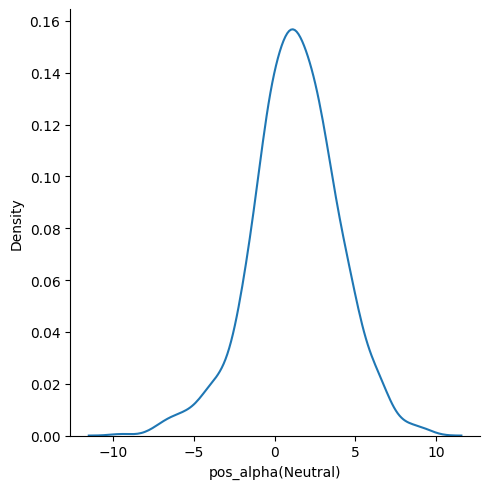

In [34]:
sns.displot(traces.loc[traces['subject'] == 10, 'pos_alpha(Neutral)'], kind = 'kde')


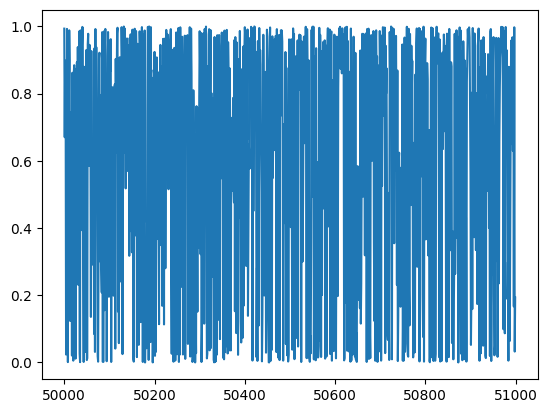

In [147]:
plt.plot(traces.loc[traces['subject'] == 50, 'alpha(Neutral)'])

In [5]:
# traces['alpha'] = np.exp(traces['alpha'])/(1 + np.exp(traces['alpha']))
# traces['pos_alpha'] = np.exp(traces['pos_alpha'])/(1 + np.exp(traces['pos_alpha']))

traces['alpha(Neutral)'] = np.exp(traces['alpha(Neutral)'])/(1 + np.exp(traces['alpha(Neutral)']))
traces['pos_alpha(Neutral)'] = np.exp(traces['pos_alpha(Neutral)'])/(1 + np.exp(traces['pos_alpha(Neutral)']))
traces['alpha(Stressed)'] = np.exp(traces['alpha(Stressed)'])/(1 + np.exp(traces['alpha(Stressed)']))
traces['pos_alpha(Stressed)'] = np.exp(traces['pos_alpha(Stressed)'])/(1 + np.exp(traces['pos_alpha(Stressed)']))


In [6]:
sub = 20
param = 'alpha(Stressed)'

sns.displot(traces.loc[traces.subject == sub, param].values, kind='kde')
plt.show()
plt.plot(traces.loc[traces.subject == sub, param].values)

# sns.displot(traces.loc[traces.subject == 21, param].values, kind='kde')


AttributeError: 'DataFrame' object has no attribute 'subject'

In [51]:
param = 'pos_alpha'
traces_corr = np.zeros((148, 148))
for participant_i in range(148):
    for participant_j in range(148):
        traces_corr[participant_i][participant_j] = stat.pearsonr(traces.loc[traces.subject == participant_i, param].values, traces.loc[traces.subject == participant_j, param].values)[0]

AttributeError: 'DataFrame' object has no attribute 'subject'

Text(0.5, 1.0, 'alpha loss')

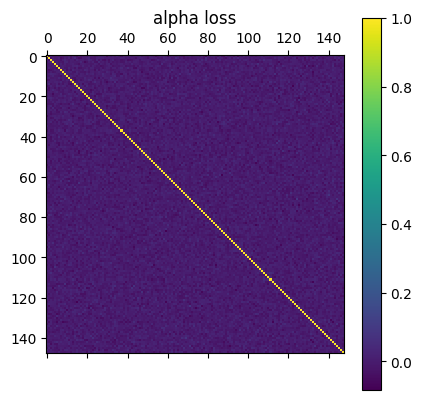

In [12]:
plt.matshow(traces_corr)
cb = plt.colorbar()
plt.title('alpha loss')

In [5]:
traces

,trace#,v(Neutral),v(Stressed),v_std,v_subj(Neutral).0,v_subj(Neutral).1,v_subj(Neutral).2,v_subj(Neutral).3,v_subj(Neutral).4,v_subj(Neutral).5,...,alpha_subj(Stressed).139,alpha_subj(Stressed).140,alpha_subj(Stressed).141,alpha_subj(Stressed).142,alpha_subj(Stressed).143,alpha_subj(Stressed).144,alpha_subj(Stressed).145,alpha_subj(Stressed).146,alpha_subj(Stressed).147,chain
0,0,0.376388,0.529142,0.152187,0.587537,0.276287,0.388654,0.029981,0.363891,0.385744,...,-2.764018,12.615208,7.250285,10.713206,-0.539207,12.296423,0.001051,-15.863545,8.004518,0
1,1,0.364932,0.527035,0.148421,0.384121,0.364066,0.182302,0.133500,0.213617,0.280759,...,-2.854632,16.776427,12.585965,10.727145,4.513386,8.806975,4.711009,-10.244852,0.719573,0
2,2,0.376508,0.523680,0.132941,0.251469,0.373050,0.273447,0.301561,0.300469,0.253723,...,-3.246991,10.224853,3.829503,14.401566,6.262722,11.912171,4.426285,-7.202007,19.211963,0
3,3,0.380332,0.558469,0.144856,0.471842,0.361046,0.390792,0.278875,0.273180,0.382670,...,-2.662599,24.439181,3.755587,20.826221,1.711534,-8.119193,10.926559,-10.060091,5.517101,0
4,4,0.389076,0.531649,0.138255,0.500781,0.582066,0.227467,0.289198,0.202151,0.414304,...,-3.531816,17.792830,-2.758593,6.473128,5.208873,14.208663,4.507639,-25.015299,7.678271,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,7995,0.379650,0.563911,0.118988,0.281317,0.029912,0.501329,0.507215,0.530107,0.488951,...,-2.291087,-5.999941,12.379963,7.207385,21.192576,5.868273,2.552956,-20.077033,0.420610,7
7996,7996,0.351528,0.547100,0.141658,0.275432,0.285710,0.214363,0.506475,0.372838,0.426769,...,-4.794332,-8.693511,7.690945,16.814289,1.083131,4.192727,3.912110,-9.153496,2.821243,7
7997,7997,0.361450,0.526216,0.142955,0.191793,0.336695,0.308782,0.624383,0.445934,0.460888,...,-4.046368,6.595531,5.120860,4.810160,6.458740,5.870638,-0.825572,-14.908166,14.121904,7
7998,7998,0.334750,0.546335,0.157904,0.577902,0.425115,0.550367,0.009118,0.293370,0.284116,...,-2.459044,2.418441,-3.901972,-0.728440,13.494893,3.965231,19.723668,-19.611438,-6.112945,7


In [7]:
# traces = pd.read_csv('non_hierarchical_traces.csv')
# beta_traces_stressed = traces.iloc[:, range(1 + 148*,149)]

alpha_l_traces_neutral = traces.iloc[:, range(7+148*2,7+148*3)]

alpha_l_traces_stressed = traces.iloc[:, range(7+148*3,7+148*4)]

alpha_g_traces_neutral = traces.iloc[:, range(10+148*4,10+148*5)]

alpha_g_traces_stressed = traces.iloc[:, range(10+148*5,10+148*6)]

beta_traces_neutral = traces.iloc[:, range(4, 4+148)]
beta_traces_stressed = traces.iloc[:, range(4+148, 4+148*2)]


In [8]:
alpha_l_traces_stressed = np.exp(alpha_l_traces_stressed)/(1+np.exp(alpha_l_traces_stressed))
alpha_l_traces_neutral = np.exp(alpha_l_traces_neutral)/(1+np.exp(alpha_l_traces_neutral))


alpha_g_traces_stressed = np.exp(alpha_g_traces_stressed)/(1+np.exp(alpha_g_traces_stressed))
alpha_g_traces_neutral = np.exp(alpha_g_traces_neutral)/(1+np.exp(alpha_g_traces_neutral))


In [13]:
def plot_chains(participant, var):
    for chain in range(8):
        plt.plot(var.iloc[chain*3000:(chain+1)*3000, participant].values)
        plt.ylim((0, 1))
#     plt.show()
#     plt.hist(alpha_l_traces_stressed.iloc[chain*3000:(chain+1)*3000, participant].values)

    #     sns.displot(var.iloc[chain*3000:(chain+1)*3000, participant].values, kind = 'kde')
    # plt.xlim((0, 1))

#     plt.show()


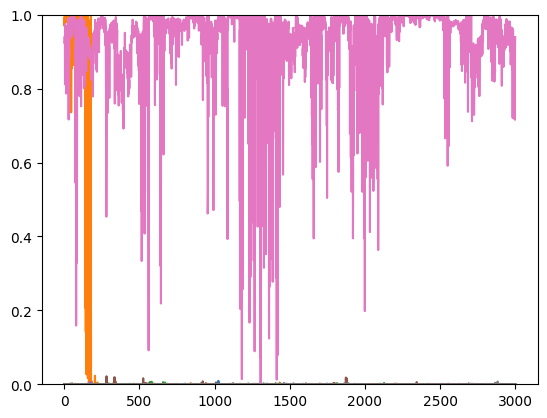

In [17]:
plot_chains(120, alpha_l_traces_neutral)


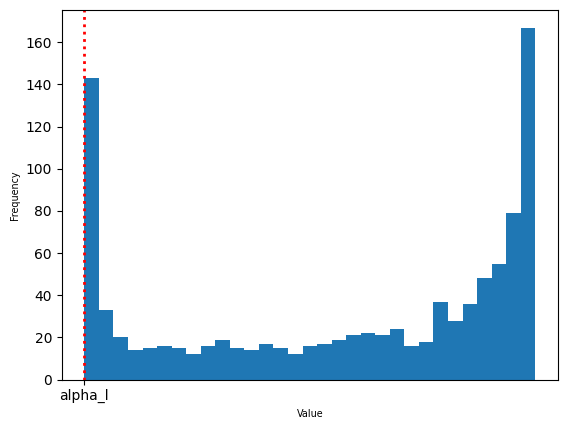

In [159]:
Matplot.gof_plot(traces.loc[traces['subject'] == 50, 'alpha(Neutral)'].values, 'alpha_l')

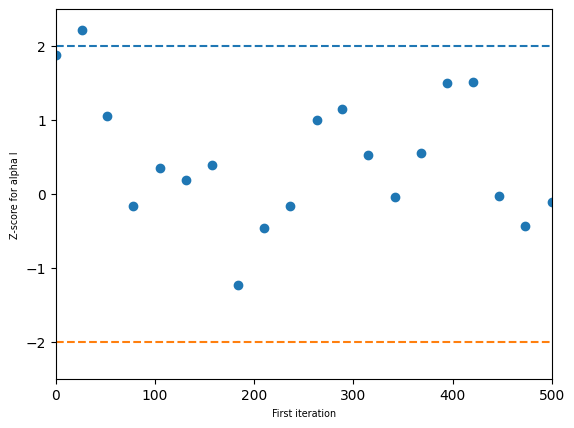

In [35]:
trace_no = 5
Matplot.geweke_plot(geweke(traces.loc[traces['subject'] == 50, 'alpha(Neutral)']), 'alpha l')

<AxesSubplot:title={'center':'x'}, xlabel='Total number of draws', ylabel='ESS'>

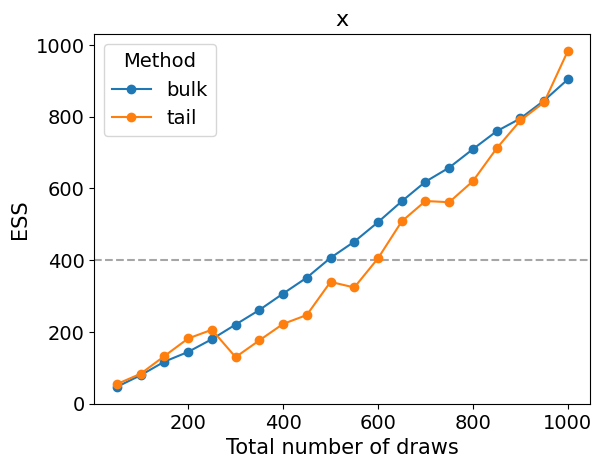

In [37]:
az.plot_ess(traces.loc[traces['subject'] == 50, 'alpha(Neutral)'].values, kind = 'evolution')

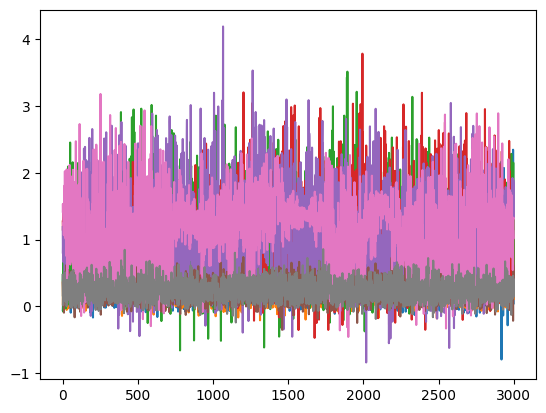

In [17]:
participant = 40
for chain in range(8):
    plt.plot(traces.iloc[chain*3000:(chain+1)*3000, participant].values)


In [13]:
alpha_l_traces_stressed.iloc[chain*3000:(chain+1)*3000, :]

,alpha_subj(Neutral).0,alpha_subj(Neutral).1,alpha_subj(Neutral).2,alpha_subj(Neutral).3,alpha_subj(Neutral).4,alpha_subj(Neutral).5,alpha_subj(Neutral).6,alpha_subj(Neutral).7,alpha_subj(Neutral).8,alpha_subj(Neutral).9,...,alpha_subj(Neutral).138,alpha_subj(Neutral).139,alpha_subj(Neutral).140,alpha_subj(Neutral).141,alpha_subj(Neutral).142,alpha_subj(Neutral).143,alpha_subj(Neutral).144,alpha_subj(Neutral).145,alpha_subj(Neutral).146,alpha_subj(Neutral).147
21000,0.709445,0.749260,0.753413,7.237159e-01,0.767552,7.643339e-01,0.689006,0.723715,0.693129,0.713439,...,0.721904,0.716619,0.695960,0.770861,0.707611,0.761208,0.751245,0.720928,0.664220,0.759679
21001,0.710430,0.718647,0.665997,7.373344e-01,0.765831,7.677886e-01,0.736341,0.771910,0.686336,0.738430,...,0.755433,0.705601,0.819590,0.762235,0.719449,0.760335,0.729718,0.686550,0.681033,0.767380
21002,0.772037,0.733917,0.738111,7.134562e-01,0.739486,7.827066e-01,0.711968,0.665361,0.729815,0.732064,...,0.705721,0.704565,0.729404,0.735675,0.734677,0.725819,0.737600,0.743493,0.717767,0.678797
21003,0.799463,0.746512,0.769056,6.635705e-01,0.769039,6.679538e-01,0.666261,0.698569,0.742943,0.748047,...,0.732793,0.690986,0.744914,0.667631,0.780368,0.717094,0.778368,0.745277,0.701655,0.776196
21004,0.747537,0.735692,0.692760,7.139532e-01,0.724138,7.667860e-01,0.671421,0.731692,0.686690,0.747476,...,0.690494,0.708764,0.732067,0.676531,0.774370,0.770928,0.764242,0.674017,0.732644,0.684746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.000007,0.000005,0.000004,5.507490e-07,0.000022,8.679893e-06,0.000021,0.000011,0.000001,0.000002,...,0.000010,0.000005,0.000008,0.000003,0.000005,0.000004,0.000010,0.000004,0.000001,0.000040
23996,0.000006,0.000005,0.000023,7.002826e-06,0.000003,3.975556e-06,0.000032,0.000013,0.000001,0.000027,...,0.000012,0.000002,0.000003,0.000025,0.000004,0.000010,0.000022,0.000002,0.000018,0.000012
23997,0.000007,0.000003,0.000006,8.628803e-06,0.000006,7.942541e-06,0.000005,0.000008,0.000017,0.000013,...,0.000012,0.000002,0.000006,0.000022,0.000006,0.000060,0.000007,0.000003,0.000014,0.000006
23998,0.000004,0.000008,0.000008,1.814854e-05,0.000016,4.410811e-07,0.000011,0.000004,0.000022,0.000017,...,0.000006,0.000015,0.000011,0.000003,0.000007,0.000001,0.000007,0.000004,0.000008,0.000005


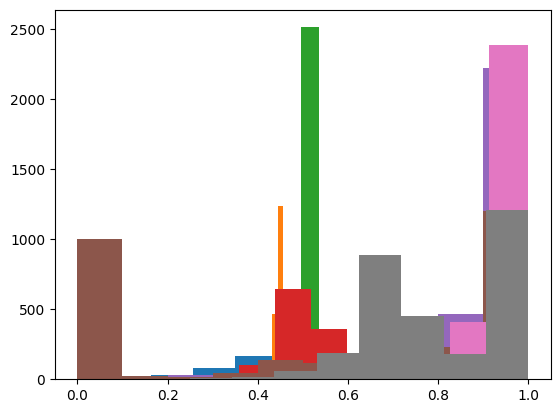

In [41]:
participant = 20
for chain in range(8):
#     plt.plot(alpha_l_traces_stressed.iloc[chain*3000:(chain+1)*3000, participant].values)
    plt.hist(alpha_l_traces_stressed.iloc[chain*3000:(chain+1)*3000, participant].values)


Text(0.5, 1.0, 'Aplha Loss Neutral')

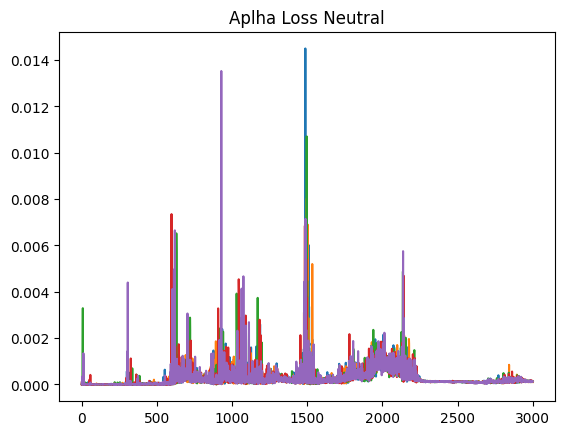

In [285]:
plt.plot(alpha_l_traces_stressed.iloc[3000:,0].values)
plt.plot(alpha_l_traces_stressed.iloc[3000:,1].values)
plt.plot(alpha_l_traces_stressed.iloc[3000:,2].values)
plt.plot(alpha_l_traces_stressed.iloc[3000:,3].values)
plt.plot(alpha_l_traces_stressed.iloc[3000:,4].values)

plt.title('Aplha Loss Neutral')

Text(0.5, 1.0, 'Alpha Gain Stressed')

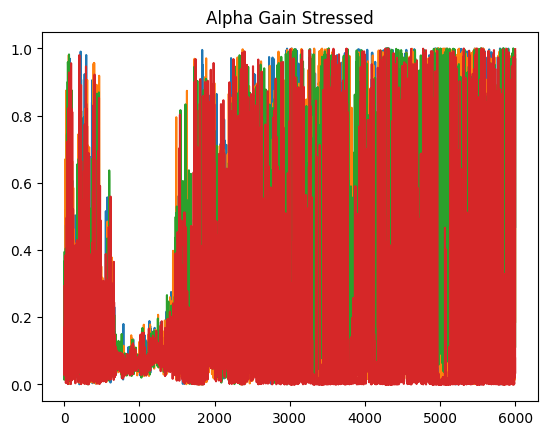

In [271]:
plt.plot(alpha_g_traces_stressed.iloc[:,0].values)
plt.plot(alpha_g_traces_stressed.iloc[:,1].values)
plt.plot(alpha_g_traces_stressed.iloc[:,2].values)
plt.plot(alpha_g_traces_stressed.iloc[:,3].values)
plt.title('Alpha Gain Stressed')

Text(0.5, 1.0, 'Beta Stressed')

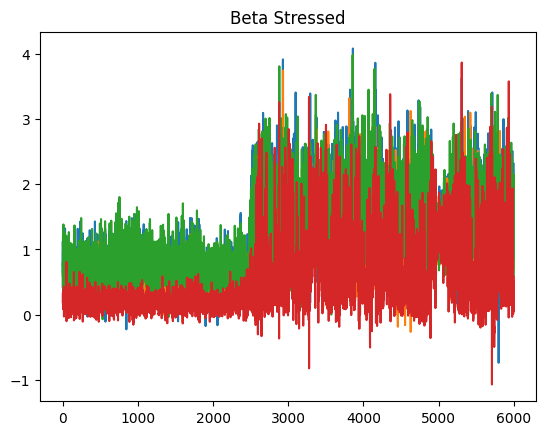

In [277]:
plt.plot(beta_traces_stressed.iloc[:,0].values)
plt.plot(beta_traces_stressed.iloc[:,1].values)
plt.plot(beta_traces_stressed.iloc[:,2].values)
plt.plot(beta_traces_stressed.iloc[:,3].values)
plt.title('Beta Stressed')

Text(0.5, 1.0, 'Alpha Loss Neutral')

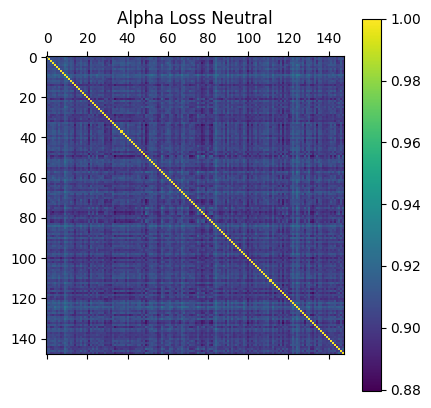

In [35]:
plt.matshow(alpha_l_traces_stressed.corr())
cb = plt.colorbar()
plt.title('Alpha Loss Neutral')

In [26]:
traces

,trace#,v_subj(Neutral).1001,v_subj(Neutral).1002,v_subj(Neutral).1003,v_subj(Neutral).1004,v_subj(Neutral).1005,v_subj(Neutral).1006,v_subj(Neutral).1007,v_subj(Neutral).1009,v_subj(Neutral).1011,...,pos_alpha_subj(Stressed).1227,pos_alpha_subj(Stressed).1228,pos_alpha_subj(Stressed).1229,pos_alpha_subj(Stressed).1230,pos_alpha_subj(Stressed).1231,pos_alpha_subj(Stressed).1232,pos_alpha_subj(Stressed).1237,pos_alpha_subj(Stressed).1243,pos_alpha_subj(Stressed).1247,pos_alpha_subj(Stressed).1249
0,0,0.029903,-0.039134,0.034183,0.184112,0.040938,0.350309,0.411380,0.048479,0.132578,...,-0.439923,-1.075831,-0.515417,-0.430046,-1.105739,0.819924,-1.310323,0.457256,0.881738,0.024868
1,1,0.366367,-0.083299,-0.399781,0.151578,0.016453,-0.001424,0.620762,0.221516,0.149196,...,0.252068,-0.060226,0.279486,-0.211685,-0.186464,-1.181504,-1.711932,0.477200,0.231048,-1.244038
2,2,0.229726,-0.066812,-0.343848,0.082362,0.019411,0.497573,0.626950,0.325959,0.204904,...,0.168571,-2.485794,-0.470749,-0.063211,0.402376,-0.298957,-1.309395,0.092458,-0.497235,-1.453153
3,3,0.162186,-0.144125,0.000877,0.212162,-0.071375,0.148373,0.522429,0.170610,0.162229,...,0.064314,0.369088,-0.005620,-0.731423,0.242072,-1.649430,0.591059,-0.288653,-0.342907,0.086320
4,4,0.379577,-0.087884,-0.105505,0.253899,-0.012772,0.060058,0.531749,0.213135,0.166050,...,1.272461,-0.992769,0.725387,-1.281259,0.421960,0.192549,-0.236082,-1.250505,-1.051666,-0.667351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,0.492073,0.154232,-0.081988,0.435237,-0.034100,0.203057,0.373269,0.350930,0.369441,...,-2.448346,0.725433,1.226183,2.423461,1.803074,2.160093,2.563774,-0.826662,11.067562,-1.798702
2996,2996,-0.215581,-0.226232,-0.027959,0.324292,-0.163487,0.329424,0.562902,0.218108,0.196141,...,3.839343,1.419904,-0.047518,8.175656,-4.655764,1.174284,0.644791,1.632369,-1.427574,-1.074820
2997,2997,0.118326,-0.369620,-0.067286,0.425057,0.073191,0.096413,0.496309,0.384373,0.254282,...,-1.789965,-2.370185,1.704978,-3.282537,4.528257,1.279255,-3.670981,2.292277,2.922054,-0.469925
2998,2998,0.142425,-0.135698,-0.183635,0.430008,-0.038479,0.164332,0.251911,0.398588,0.103799,...,-3.524078,-2.792114,-1.121180,0.861291,-2.279373,-0.294365,-2.417826,1.516108,-4.685720,0.002790


In [15]:
traces_melt = traces.melt(id_vars='trace#', var_name='parameters', value_name='parameter values')

In [17]:
neutral_traces_melt = traces_melt.loc[traces_melt.parameters.str.contains('Neutral')].reset_index()
stressed_traces_melt = traces_melt.loc[traces_melt.parameters.str.contains('Stressed')].reset_index()


In [56]:
neutral_traces_melt.sample()

,index,trace#,parameters,parameter values
1129394,2023394,1394,pos_alpha_subj(Neutral).1097,-2.392515


# Optimal Parameters

In [6]:
rng = np.random.default_rng(12345)

def optimal_model(rng, alpha_l, alpha_g, num_trials):
    Q = np.zeros(2)+0.5
    choices = []
    for i in range(num_trials):
#         choice_a = np.random.choice([0, 1], p = softmax(Q))
        choice_a = np.argmax(Q)
        if choice_a == 0:
            reward = np.random.choice([1, 0], p=[0.8, 0.2])
        else:
            reward = np.random.choice([1, 0], p=[0.2, 0.8])
            
        pred_error = reward - Q[choice_a]
        if pred_error > 0:
            alpha = alpha_l
        else:
            alpha = alpha_g
        Q[choice_a] = Q[choice_a] + alpha*pred_error
        choices.append(choice_a)
    return 1 - (sum(choices)/len(choices))


In [7]:
num_trials = 1000
n_sims = 1000
df = []
for (alpha_l, alpha_g) in zip([0.1, 0.6, 0.9, 1], [0.1, 0.6, 0.9, 1]):
    optimal_choice_proportion = np.zeros(n_sims)
    for i in range(n_sims):
        optimal_choice_proportion[i] = optimal_model(rng, alpha_l, alpha_g, num_trials)
    df.append(pd.DataFrame({'Alpha_l': np.repeat(alpha_l, n_sims), 'Alpha_g': np.repeat(alpha_g, n_sims), 'optimal choice proportion': optimal_choice_proportion}))


In [8]:
sim_data = pd.concat(df)

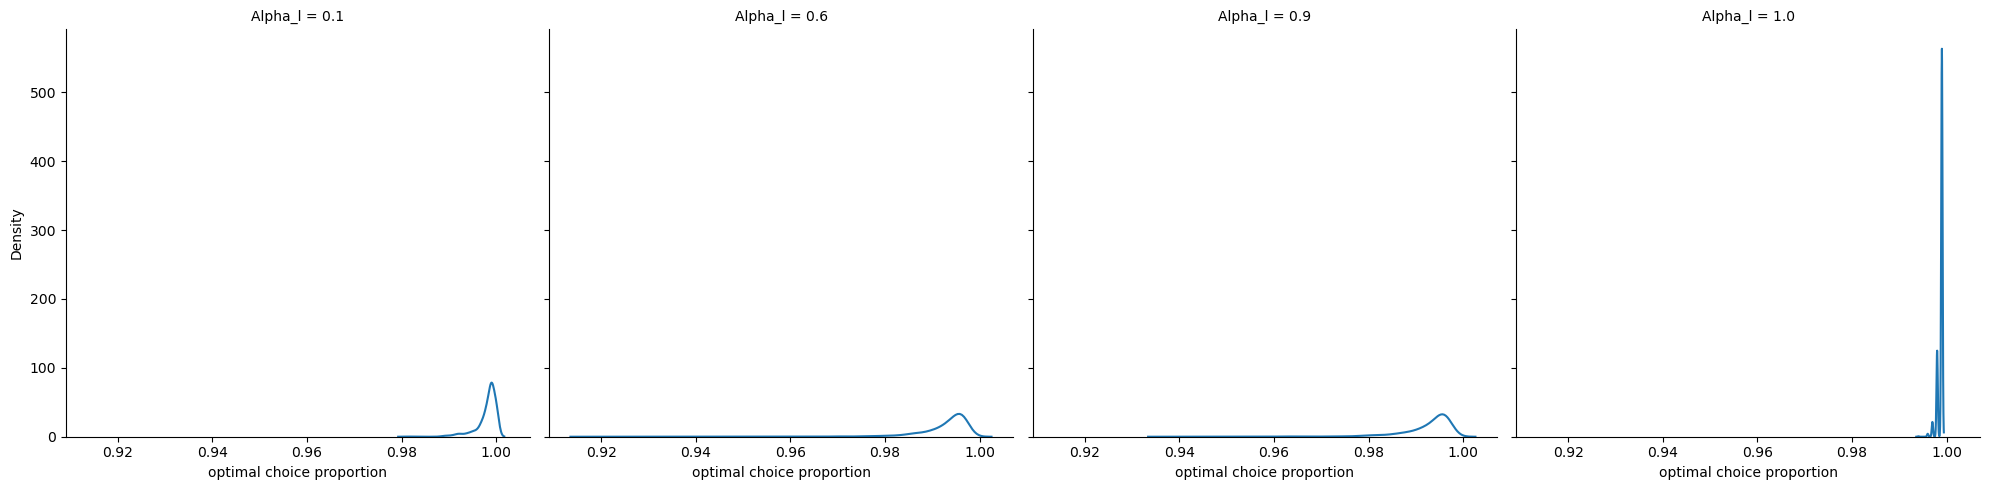

In [9]:
sns.displot(x = 'optimal choice proportion', data = sim_data, col = 'Alpha_l', kind = 'kde')

# Posterior Predictive checks

In [42]:
traces = pd.read_csv('model_traces/10k4k5p6thin_indsubj_neutral_traces.csv').drop('Unnamed: 0', axis = 1)

In [52]:
data = pd.read_csv('df_neutral.csv').drop('Unnamed: 0', axis = 1).reset_index().drop('index', axis = 1)

In [53]:
data

,subj_idx,response,feedback,cond,Session,trial,rt,q_init,split_by,BPD,Condition
0,0,1,1.0,AB,Neutral,0.0,0.5,0.5,0.0,No BPD,1
1,0,1,1.0,EF,Neutral,0.0,0.5,0.5,2.0,No BPD,1
2,0,0,0.0,CD,Neutral,0.0,0.5,0.5,1.0,No BPD,1
3,0,0,0.0,CD,Neutral,1.0,0.5,0.5,1.0,No BPD,1
4,0,1,1.0,AB,Neutral,1.0,0.5,0.5,0.0,No BPD,1
...,...,...,...,...,...,...,...,...,...,...,...
30595,147,1,1.0,CD,Neutral,18.0,0.5,0.5,1.0,No BPD,2
30596,147,1,1.0,AB,Neutral,18.0,0.5,0.5,0.0,No BPD,2
30597,147,1,1.0,AB,Neutral,19.0,0.5,0.5,0.0,No BPD,2
30598,147,1,1.0,CD,Neutral,19.0,0.5,0.5,1.0,No BPD,2


In [76]:
subject = 0
sample = np.random.randint(0,1000) #Random row
invalpha = traces.loc[((traces['subject'] == subject))].iloc[sample]['alpha']
inv_posalpha = traces.loc[((traces['subject'] == subject))].iloc[sample]['pos_alpha']
v = traces.loc[((traces['subject'] == subject))].iloc[sample]['v']
alpha = np.exp(invalpha)/(1 + np.exp(invalpha))
pos_alpha = np.exp(inv_posalpha)/(1 + np.exp(inv_posalpha))


size0 = len(data[(data['subj_idx']==subject) & (data['split_by']==0)].trial.unique())
size1 = len(data[(data['subj_idx']==subject) & (data['split_by']==1)].trial.unique())
size2 = len(data[(data['subj_idx']==subject) & (data['split_by']==2)].trial.unique())


sim_data0 = hddm.generate.gen_rand_rl_data(scaler=v,alpha=alpha, pos_alpha=pos_alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
sim_data1 = hddm.generate.gen_rand_rl_data(scaler=v,alpha=alpha, pos_alpha=pos_alpha,size=size0,p_upper=0.7,p_lower=0.3,split_by=1)
sim_data2 = hddm.generate.gen_rand_rl_data(scaler=v,alpha=alpha, pos_alpha=pos_alpha,size=size0,p_upper=0.6,p_lower=0.4,split_by=2)


In [77]:
sim_data = pd.concat([sim_data0, sim_data1, sim_data2])


In [83]:
sim_data['bin trial'] = pd.cut(sim_data.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
sums = sim_data.groupby(['bin trial','split_by', 'subj_idx']).mean().reset_index()
data.loc[data['subj_idx'] == subject, 'bin trial'] = sim_data['bin trial'].values
datasub = data[data['subj_idx'] == subject]

In [89]:
# datasub.groupby(['subj_idx', 'cond', 'split_by','bin trial']).mean().reset_index()
sim_data.groupby(['subject', 'cond', 'split_by','bin trial']).mean().reset_index()


KeyError: 'subject'

ValueError: x and y must be the same size

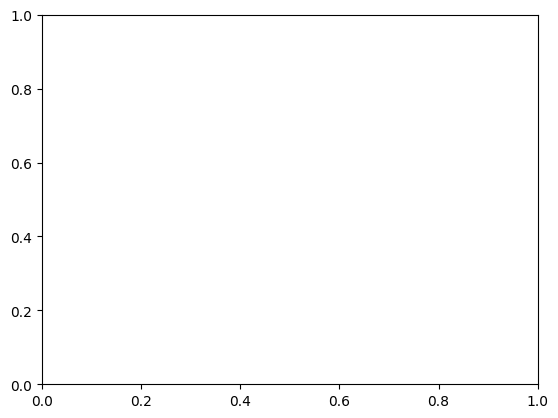

In [99]:
plt.plot(sim_data.loc[sim_data['split_by'] == 1))])

,bin trial,split_by,subj_idx,q_up,q_low,p,sim_drift,response,feedback,trial
0,0,0,0,0.606752,0.172595,0.483935,-0.064360,0.545455,0.454545,6.0
1,0,1,0,0.639210,0.301101,0.487480,-0.050122,0.363636,0.363636,6.0
2,0,2,0,0.617554,0.342927,0.489953,-0.040711,0.727273,0.545455,6.0
3,1,0,0,0.911010,0.127257,0.470994,-0.116185,0.454545,0.454545,17.0
4,1,1,0,0.164739,0.110516,0.498118,-0.008038,0.000000,0.090909,17.0
5,1,2,0,0.657823,0.600846,0.497685,-0.008446,0.363636,0.636364,17.0
6,2,0,0,0.833734,0.121129,0.473625,-0.105637,0.363636,0.272727,28.0
7,2,1,0,0.627399,0.172280,0.483218,-0.067467,0.636364,0.545455,28.0
8,2,2,0,0.863221,0.271911,0.478107,-0.087656,0.363636,0.545455,28.0
9,3,0,0,0.629756,0.187327,0.483623,-0.065586,0.272727,0.363636,39.0


In [57]:
data = df.copy()

In [61]:
from tqdm import tqdm
sim_data = pd.DataFrame()
#create a column samp to be used to identify the simulated data sets
data['samp'] = 0
#load traces
traces = traces.loc[:1000]
#decide how many times to repeat simulation process. repeating this multiple times is generally recommended as it better captures the uncertainty in the posterior distribution, but will also take some time
for i in tqdm(range(1,51)):
    #randomly select a row in the traces to use for extracting parameter values
    sample = np.random.randint(0,traces.shape[0]-1)
    #loop through all subjects in observed data
    for s in data.subj_idx.unique():
        #get number of trials for each condition.
        size0 = len(data[(data['subj_idx']==s) & (data['split_by']==0)].trial.unique())
        size1 = len(data[(data['subj_idx']==s) & (data['split_by']==1)].trial.unique())
        size2 = len(data[(data['subj_idx']==s) & (data['split_by']==2)].trial.unique())
        #set parameter values for simulation
        scaler = traces.loc[sample,'v_subj(Neutral).'+str(s)]
        alphaInv = traces.loc[sample,'alpha_subj(Neutral).'+str(s)]
        pos_alphaInv = traces.loc[sample, 'pos_alpha_subj(Neutral).'+str(s)]
        #take inverse logit of estimated alpha
        alpha = np.exp(alphaInv)/(1+np.exp(alphaInv))
        pos_alpha = np.exp(pos_alphaInv)/(1+np.exp(pos_alphaInv))

        #simulate data for each condition changing only values of size, p_upper, p_lower and split_by between conditions.
        sim_data0 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha, pos_alpha=pos_alpha,size=size0,p_upper=0.8,p_lower=0.2,split_by=0)
        sim_data1 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha, pos_alpha=pos_alpha, size=size1, p_upper=0.7,p_lower=0.3,split_by=1)
        sim_data2 = hddm.generate.gen_rand_rl_data(scaler=scaler,alpha=alpha,size=size2, pos_alpha=pos_alpha, p_upper=0.6,p_lower=0.4,split_by=2)
        #append the conditions
        sim_data0 = sim_data0.append([sim_data1,sim_data2],ignore_index=True)
        #assign subj_idx
        sim_data0['subj_idx'] = s
        #identify that these are simulated data
        sim_data0['type'] = 'simulated'
        #identify the simulated data
        sim_data0['samp'] = i
        #append data from each subject
        sim_data = sim_data.append(sim_data0,ignore_index=True)
#combine observed and simulated data
ppc_rl_data = data[['subj_idx','response','split_by','trial','feedback','samp']].copy()
ppc_rl_data['type'] = 'observed'
ppc_rl_sdata = sim_data[['subj_idx','response','split_by','trial','feedback','type','samp']].copy()
ppc_rl_data = ppc_rl_data.append(ppc_rl_sdata)

100%|██████████| 50/50 [1:17:34<00:00, 93.10s/it] 


,subj_idx,response,split_by,trial,feedback,type,samp
0,0,1.0,0,1,1.0,simulated,1
1,0,0.0,0,2,0.0,simulated,1
2,0,0.0,0,3,0.0,simulated,1
3,0,1.0,0,4,1.0,simulated,1
4,0,0.0,0,5,1.0,simulated,1
...,...,...,...,...,...,...,...
1787995,147,0.0,2,16,0.0,simulated,50
1787996,147,1.0,2,17,1.0,simulated,50
1787997,147,1.0,2,18,0.0,simulated,50
1787998,147,0.0,2,19,0.0,simulated,50


In [72]:
plot_ppc_rl_data = ppc_rl_data.copy()

In [77]:
plot_ppc_rl_data

,subj_idx,response,split_by,trial,feedback,samp,type,bin_trial
0,0,1.0,0.0,0.0,1.0,0,observed,0
1,0,1.0,2.0,0.0,1.0,0,observed,0
2,0,0.0,1.0,0.0,0.0,0,observed,0
3,0,0.0,1.0,1.0,0.0,0,observed,0
4,0,1.0,0.0,1.0,1.0,0,observed,0
...,...,...,...,...,...,...,...,...
1787995,147,0.0,2.0,16.0,0.0,50,simulated,1
1787996,147,1.0,2.0,17.0,1.0,50,simulated,1
1787997,147,1.0,2.0,18.0,0.0,50,simulated,1
1787998,147,0.0,2.0,19.0,0.0,50,simulated,1


In [78]:
plot_ppc_rl_data['bin_trial'] = pd.cut(plot_ppc_rl_data.trial,11,labels=np.linspace(0, 10,11)).astype('int64')
#calculate means for each sample
sums = plot_ppc_rl_data.groupby(['bin_trial','split_by','samp','type', 'subj_idx']).mean().reset_index()
#calculate the overall mean response across samples
ppc_rl_sim = sums.groupby(['bin_trial','split_by','type', 'subj_idx']).mean().reset_index()
#initiate columns that will have the upper and lower bound of the hpd
ppc_rl_sim['upper_hpd'] = 0
ppc_rl_sim['lower_hpd'] = 0
for i in range(0,ppc_rl_sim.shape[0]):
    #calculate the hpd/hdi of the predicted mean responses across bin_trials
    hdi = pymc.utils.hpd(sums.response[(sums['bin_trial']==ppc_rl_sim.bin_trial[i]) & (sums['split_by']==ppc_rl_sim.split_by[i]) & (sums['type']==ppc_rl_sim.type[i])],alpha=0.1)
    ppc_rl_sim.loc[i,'upper_hpd'] = hdi[1]
    ppc_rl_sim.loc[i,'lower_hpd'] = hdi[0]
#calculate error term as the distance from upper bound to mean
ppc_rl_sim['up_err'] = ppc_rl_sim['upper_hpd']-ppc_rl_sim['response']
ppc_rl_sim['low_err'] = ppc_rl_sim['response']-ppc_rl_sim['lower_hpd']
ppc_rl_sim['model'] = 'RL'

In [79]:
ppc_rl_sim

,bin_trial,split_by,type,subj_idx,samp,response,trial,feedback,upper_hpd,lower_hpd,up_err,low_err,model
0,0,0.0,observed,0,0.0,0.681818,5.0,0.681818,0.863636,0.409091,0.181818,0.272727,RL
1,0,0.0,observed,1,0.0,0.500000,5.0,0.500000,0.863636,0.409091,0.363636,0.090909,RL
2,0,0.0,observed,2,0.0,0.681818,5.0,0.681818,0.863636,0.409091,0.181818,0.272727,RL
3,0,0.0,observed,3,0.0,0.727273,5.0,0.727273,0.863636,0.409091,0.136364,0.318182,RL
4,0,0.0,observed,4,0.0,0.636364,5.0,0.636364,0.863636,0.409091,0.227273,0.227273,RL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6799,10,2.0,simulated,142,25.5,0.534545,115.0,0.469091,0.727273,0.272727,0.192727,0.261818,RL
6800,10,2.0,simulated,143,25.5,0.507273,115.0,0.505455,0.727273,0.272727,0.220000,0.234545,RL
6801,10,2.0,simulated,144,25.5,0.520000,115.0,0.503636,0.727273,0.272727,0.207273,0.247273,RL
6802,10,2.0,simulated,145,25.5,0.507273,115.0,0.483636,0.727273,0.272727,0.220000,0.234545,RL


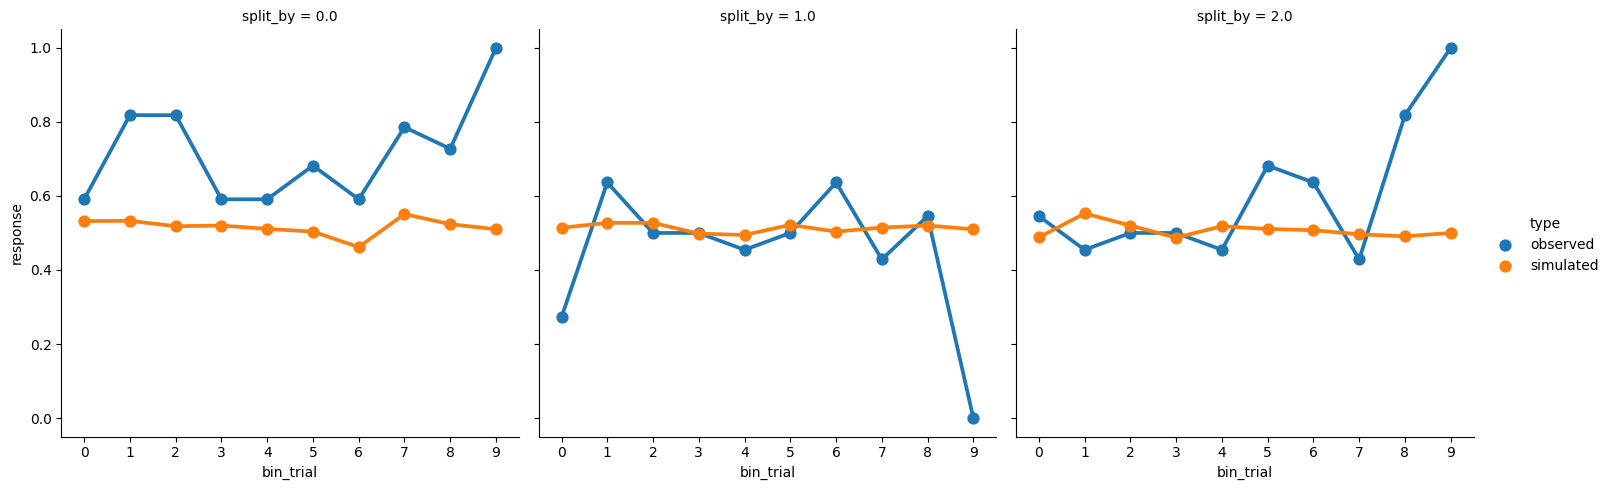

In [99]:
sns.catplot(x = 'bin_trial', y = 'response', hue = 'type', col = 'split_by', 
            data = ppc_rl_sim[ppc_rl_sim['subj_idx'] == 121], kind = 'point')

# Other stuff tried

In [8]:
def llik_td (alpha_l, alpha_g, beta, actions, rewards, stimuli):
    # Extract the arguments as they are passed by scipy.optimize.minimize

    # Initialize values
    Q = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])
    logp_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions, rewards)):
        # Apply the softmax transformation
        exp_Q = np.exp(Q[stimuli[t]]*beta)
        
        prob_a = exp_Q / np.sum(exp_Q)

#         logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = np.log(prob_a[a%2])
        
        

        # Update the Q values for the next trial
        pred_error = r - Q[a]
        if pred_error > 0:
            alpha = alpha_g
        else:
            alpha = alpha_l
            
        Q[a] = Q[a] + alpha * pred_error

    # Return the negative log likelihood of all observed actions
    return np.sum(logp_actions[1:])


# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, actions, rewards, stimuli):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.actions = actions
        self.rewards = rewards
        self.stimuli = stimuli

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta[0], theta[1], theta[2], self.actions, self.rewards, self.stimuli)

        outputs[0][0] = np.array(logl)  # output the log-likelihood
        
        

NameError: name 'pt' is not defined

In [ ]:
logl = LogLike(llik_td, actions, rewards, trials_presented)

with pm.Model() as m:
    
    
    alpha_l = pm.Uniform("alpha_l", 0, 1)
    alpha_g = pm.Uniform("alpha_g", 0, 1)
    beta = pm.Uniform("beta", lower=0.1, upper = 3)
    theta = pt.as_tensor_variable([alpha_l, alpha_g, beta])

    like = pm.Potential("like", logl(theta))
#     actions = pm.Categorical('actions', )
    tr = pm.sample(random_seed=rng)

In [ ]:
def update_Q(action, reward, Qs, alpha_l, alpha_g):
    """
    This function updates the Q table according to the RL update rule.
    It will be called by pytensor.scan to do so recursevely, given the observed data and the alpha parameter
    This could have been replaced be the following lamba expression in the pytensor.scan fn argument:
        fn=lamba action, reward, Qs, alpha: pt.set_subtensor(Qs[action], Qs[action] + alpha * (reward - Qs[action]))
    """
    pred_error = reward - Qs[action]

    if pt.gt(reward, Qs[action]): #If reward greater than Qs[action]
        alpha = alpha_g
    else:
        alpha = alpha_l
    Qs = pt.set_subtensor(Qs[action], Qs[action] + alpha * pred_error)
    return Qs

def correct_action_probs(alpha_l, alpha_g, beta, actions, rewards, stimuli):
    rewards = pt.as_tensor_variable(rewards, dtype="int32")
    actions = pt.as_tensor_variable(actions, dtype="int32")
#     stimuli = pt.as_tensor_variable(stimuli, dtype="int32")
    

    # Compute the Qs values
    Qs = 0.5 * pt.ones((6,), dtype="float64")
    Qs, updates = pytensor.scan(
        fn=update_Q, sequences=[actions, rewards], outputs_info=[Qs], non_sequences=[alpha_l, alpha_g]
    )

    # Apply the sotfmax transformation
#     print(Qs.shape.eval())
    Qs = Qs[:-1] * beta
    logp_actions = Qs - pt.logsumexp(Qs, axis=1, keepdims=True)
    optimal_action = stimuli[stimuli%2 == 0][:-1]
    
    # Return the probabilities for the optimal action, in the original scale
    return pt.exp(logp_actions[np.arange(419), optimal_action])

In [ ]:
with pm.Model() as m_alt:
    alpha_l = pm.Uniform(name="alpha_l", lower=0.01, upper = 0.99)
    alpha_g = pm.Uniform(name="alpha_g", lower=0.01, upper = 0.99)
    
    beta = pm.HalfNormal(name="beta", sigma=10)

    action_probs = correct_action_probs(alpha_l, alpha_g,  beta, actions, rewards, trials_presented)
    like = pm.Bernoulli(name="like", p=action_probs, observed=opt_act[1:])

    tr_alt = pm.sample(random_seed=rng)

In [45]:
df_neutral  = pd.read_csv('df_neutral.csv')
df_stressed  = pd.read_csv('df_stressed.csv')
df_to_fit = pd.concat([df_neutral, df_stressed])

m = hddm.Hrl(df_to_fit)

No model attribute --> setting up standard HDDM
Set model to ddm


/home/vm01/anaconda3/envs/bpd_env/lib/python3.7/site-packages/hddm/models/base.py:1310: UserWarning:  
 Your include statement misses either the v, a or t parameters. 
Parameters not explicitly included will be set to the defaults, 
which you can find in the model_config dictionary!
  + "which you can find in the model_config dictionary!"


In [46]:
m.model_config

{'doc': 'Model used internally for simulation purposes. Do NOT use with the LAN extension.',
 'params': ['v', 'a', 'z', 't'],
 'params_trans': [0, 0, 1, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0],
 'param_bounds': [[-5.0, 0.1, 0.05, 0], [5.0, 5.0, 0.95, 3.0]],
 'boundary': <function ssms.basic_simulators.boundary_functions.constant(t=0)>,
 'params_default': [0.0, 2.0, 0.5, 0],
 'hddm_include': ['v', 'a', 't', 'z'],
 'choices': [0, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15}}

In [50]:
hddm.model_config_rl.model_config_rl['RWupdate_dual']

{'doc': 'Rescorla-Wagner update with two learning rates',
 'params': ['rl_alpha', 'rl_pos_alpha'],
 'params_trans': [0, 0],
 'params_std_upper': [10, 10],
 'param_bounds': [[0.0, 0.0], [1.0, 1.0]],
 'params_default': [0.5, 0.5]}